最初に（後ろでコメント入れているものもあり）

*   GridsearchCV, SHAP は計算量が多く比較的時間がかかるので、Colabでローカルで動かすほうが上手くいくかもしれないです
*   XGBoostは、バージョンによって予測結果が変わるようです。。。

*   ver0.9 (Colab) と ver1.5.1 (ローカルのjupyter noteboook) でやった結果、ver0.9の方がやや精度良かったです。
*   ver0.9 (Colab) で動かすとSHAPの計算でエラーが出ます。


In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import os

os.chdir('/content/drive/MyDrive/Colab_Combase2/combase_data')
os.getcwd()

Mounted at /content/drive


'/content/drive/.shortcut-targets-by-id/1xzF4Bh1e8g2kMAd6b1Vb6usH1NUdhKKf/Colab_Combase2/combase_data'

In [2]:
!pip install shap
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.6 MB/s 


In [3]:
## import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import rgb2hex
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from matplotlib.backends.backend_pdf import PdfPages
plt.rcParams['font.sans-serif'] = ['Arial'] 
import collections
from fastprogress.fastprogress import master_bar, progress_bar
from IPython.display import display
# Encoder(Category→Number)
import category_encoders as ce
from category_encoders import OrdinalEncoder
# SHAP
import shap

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
#Data preparation

data = pd.read_csv('data_CB6_all_plots_condition_div1.csv')

#select data
data = data[data['LogN'] >= 0]
data = data[data['Temperature'] <= 25]
data = data[data['Temperature'] >= 0]
data = data[
            ((data['Organism']=='Lm') | 
            (data['Organism']=='Ss') | 
            (data['Organism']=='Ec') |
            (data['Organism']=='Bc') |
            (data['Organism']=='Ye') |
            (data['Organism']=='Ah') |
            (data['Organism']=='Sa') |
            (data['Organism']=='Ps')
            )
            ]
data = data.rename(columns={'LogN':'N', 'LogN0':'N0', 'Food_category':'Category', 'Food_Name':'Name'})
data = data[
            (data['Category']=='Culture medium') |
            (data['Category']=='Beef') |
            (data['Category']=='Pork') |
            (data['Category']=='Poultry') |
            (data['Category']=='Milk') |
            (data['Category']=='Vegetable or fruit and their products') |
            (data['Category']=='Seafood') |
            (data['Category']=='Cheese') |
            (data['Category']=='Egg or egg product') |
            (data['Category']=='Dessert food') |
            (data['Category']=='Sausage') |
            (data['Category']=='Juice, beverage') |
            (data['Category']=='Bread') |
            (data['Category']=='Sauce/dressing') |
            (data['Category']=='Water')
            ]
# removing columns
del data['Assumed']
del data['source']
del data['n_plots']
del data['trial_counts']
del data['Initial']
data = data.sort_values(['Organism', 'Category'])
data = data.reset_index(drop=True)

data

,N,Time,N0,Temperature,Aw,pH,Category,Name,Organism,Record_ID,Conditions
0,3.60,0.00,3.60,5.0,NaN,7.1,Beef,Beef adipose tissue,Ah,M138_Ah,"raw, cut"
1,4.80,48.00,3.60,5.0,NaN,7.1,Beef,Beef adipose tissue,Ah,M138_Ah,"raw, cut"
2,7.20,96.00,3.60,5.0,NaN,7.1,Beef,Beef adipose tissue,Ah,M138_Ah,"raw, cut"
3,8.80,144.00,3.60,5.0,NaN,7.1,Beef,Beef adipose tissue,Ah,M138_Ah,"raw, cut"
4,9.40,192.00,3.60,5.0,NaN,7.1,Beef,Beef adipose tissue,Ah,M138_Ah,"raw, cut"
...,...,...,...,...,...,...,...,...,...,...,...
101856,3.19,168.35,3.31,5.0,0.99,5.7,Seafood,Tuna,Ye,P_26Y,"co-culture, non-sterile, CO_2(%):40, O2(%):0, ..."
101857,5.58,239.93,3.31,5.0,0.99,5.7,Seafood,Tuna,Ye,P_26Y,"co-culture, non-sterile, CO_2(%):40, O2(%):0, ..."
101858,5.19,287.93,3.31,5.0,0.99,5.7,Seafood,Tuna,Ye,P_26Y,"co-culture, non-sterile, CO_2(%):40, O2(%):0, ..."
101859,3.85,335.86,3.31,5.0,0.99,5.7,Seafood,Tuna,Ye,P_26Y,"co-culture, non-sterile, CO_2(%):40, O2(%):0, ..."


In [5]:
# prepare objective variable
data['Change_Ratio'] = data['N']-data['N0']
data = data.iloc[:, [11,1,2,3,4,5,6,7,8,9,10]]

# bacteria_fullname dictionary
Dict_Organisms = {
                  'Ah':'Aeromonas hydrophila','Bc':'Bacillus cereus', 'Ec':'Escherichia coli',
                  'Lm':'Listeria monocytogenes/innocua', 'Ps':'Pseudomonads', 'Sa':'Staphylococcus aureus', 
                  'Ss':'Salmonella spp', 'Ye':'Yersinia enterocolitica', 
                  }
# Organism full name
data['Organism'].replace(Dict_Organisms, inplace=True)

data


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Change_Ratio,Time,N0,Temperature,Aw,pH,Category,Name,Organism,Record_ID,Conditions
0,0.00,0.00,3.60,5.0,NaN,7.1,Beef,Beef adipose tissue,Aeromonas hydrophila,M138_Ah,"raw, cut"
1,1.20,48.00,3.60,5.0,NaN,7.1,Beef,Beef adipose tissue,Aeromonas hydrophila,M138_Ah,"raw, cut"
2,3.60,96.00,3.60,5.0,NaN,7.1,Beef,Beef adipose tissue,Aeromonas hydrophila,M138_Ah,"raw, cut"
3,5.20,144.00,3.60,5.0,NaN,7.1,Beef,Beef adipose tissue,Aeromonas hydrophila,M138_Ah,"raw, cut"
4,5.80,192.00,3.60,5.0,NaN,7.1,Beef,Beef adipose tissue,Aeromonas hydrophila,M138_Ah,"raw, cut"
...,...,...,...,...,...,...,...,...,...,...,...
101856,-0.12,168.35,3.31,5.0,0.99,5.7,Seafood,Tuna,Yersinia enterocolitica,P_26Y,"co-culture, non-sterile, CO_2(%):40, O2(%):0, ..."
101857,2.27,239.93,3.31,5.0,0.99,5.7,Seafood,Tuna,Yersinia enterocolitica,P_26Y,"co-culture, non-sterile, CO_2(%):40, O2(%):0, ..."
101858,1.88,287.93,3.31,5.0,0.99,5.7,Seafood,Tuna,Yersinia enterocolitica,P_26Y,"co-culture, non-sterile, CO_2(%):40, O2(%):0, ..."
101859,0.54,335.86,3.31,5.0,0.99,5.7,Seafood,Tuna,Yersinia enterocolitica,P_26Y,"co-culture, non-sterile, CO_2(%):40, O2(%):0, ..."


In [6]:
## Categorical feature List & Dictionarry 
#'food category'  
list_Category = collections.Counter(data['Category'])
list_Category = list(list_Category.keys())
keys = []
for i in range(len(list_Category)):
  m = list_Category[i]
  keys.append(m)
values = range(1,len(list_Category)+1)
Category = dict(zip(keys, values))
print(list_Category)
print(Category)
print('')
#'Food name'
list_name = collections.Counter(data['Name'])
list_name = list(list_name.keys())
keys = []
for i in range(len(list_name)):
    m = list_name[i]
    keys.append(m)
values = range(1,len(list_name)+1)
Name = dict(zip(keys, values))
print(list_name)
print('')
# 'Organism' 
list_Organism = collections.Counter(data['Organism'])
list_Organism = list(list_Organism.keys())
keys = []
for i in range(len(list_Organism)):
  m = list_Organism[i]
  keys.append(m)
values = range(1,len(list_Organism)+1)
Organism = dict(zip(keys, values))
print(Organism)
print('')

# get list of categorical columns
categorical_columns = [c for c in data.columns if (data[c].dtype == 'object')&(c != 'Conditions')&(c != 'Record_ID')]
print(categorical_columns)
print('')

# Categorical Data
for col in categorical_columns:
    print('column name: {}'.format(col))
    print('number of items: {}'.format(data[col].nunique()))
    print('')

['Beef', 'Culture medium', 'Pork', 'Poultry', 'Seafood', 'Vegetable or fruit and their products', 'Water', 'Dessert food', 'Milk', 'Sausage', 'Cheese', 'Egg or egg product', 'Juice, beverage', 'Sauce/dressing', 'Bread']
{'Beef': 1, 'Culture medium': 2, 'Pork': 3, 'Poultry': 4, 'Seafood': 5, 'Vegetable or fruit and their products': 6, 'Water': 7, 'Dessert food': 8, 'Milk': 9, 'Sausage': 10, 'Cheese': 11, 'Egg or egg product': 12, 'Juice, beverage': 13, 'Sauce/dressing': 14, 'Bread': 15}

['Beef adipose tissue', 'Beef muscle', 'Bhib', 'Broth', 'Modified complete defined synthetic (mcds) medium', 'Tsb', 'Ground pork', 'Mild cured smoked breaded ham as sold', 'Pork', 'Turkey', 'Cooked prawn with brine as sold', 'Hake', 'Salmon', 'Shrimp', 'Sole', 'Tuna', 'Asparagus', 'Broccoli', 'Cauliflower', 'Pasteurised drinking water', 'Sous-vide beef goulash', 'Cream', 'Milk', 'Chicken gravy', 'Chunky chicken in white souce', 'Sausage', 'Crab sticks', 'Pilchards', 'Boiled rice', 'Broccoli puree', 'Cab

In [7]:
# Encoding Categorical data
# Ordinary Encoding

categorical_features = [c for c in data.columns if (data[c].dtype == 'object')&(c != 'Conditions')&(c != 'Record_ID')]

encoder = OrdinalEncoder(
    cols=categorical_features,
    handle_unknown='ignore',
    handle_missing='rerun_nan',
    return_df=True
).fit(data)

data = encoder.transform(data)
data

,Change_Ratio,Time,N0,Temperature,Aw,pH,Category,Name,Organism,Record_ID,Conditions
0,0.00,0.00,3.60,5.0,NaN,7.1,1,1,1,M138_Ah,"raw, cut"
1,1.20,48.00,3.60,5.0,NaN,7.1,1,1,1,M138_Ah,"raw, cut"
2,3.60,96.00,3.60,5.0,NaN,7.1,1,1,1,M138_Ah,"raw, cut"
3,5.20,144.00,3.60,5.0,NaN,7.1,1,1,1,M138_Ah,"raw, cut"
4,5.80,192.00,3.60,5.0,NaN,7.1,1,1,1,M138_Ah,"raw, cut"
...,...,...,...,...,...,...,...,...,...,...,...
101856,-0.12,168.35,3.31,5.0,0.99,5.7,5,16,8,P_26Y,"co-culture, non-sterile, CO_2(%):40, O2(%):0, ..."
101857,2.27,239.93,3.31,5.0,0.99,5.7,5,16,8,P_26Y,"co-culture, non-sterile, CO_2(%):40, O2(%):0, ..."
101858,1.88,287.93,3.31,5.0,0.99,5.7,5,16,8,P_26Y,"co-culture, non-sterile, CO_2(%):40, O2(%):0, ..."
101859,0.54,335.86,3.31,5.0,0.99,5.7,5,16,8,P_26Y,"co-culture, non-sterile, CO_2(%):40, O2(%):0, ..."


In [8]:
print(encoder.category_mapping)

[{'col': 'Category', 'mapping': Beef                                      1
Culture medium                            2
Pork                                      3
Poultry                                   4
Seafood                                   5
Vegetable or fruit and their products     6
Water                                     7
Dessert food                              8
Milk                                      9
Sausage                                  10
Cheese                                   11
Egg or egg product                       12
Juice, beverage                          13
Sauce/dressing                           14
Bread                                    15
dtype: int64, 'data_type': dtype('O')}, {'col': 'Name', 'mapping': Beef adipose tissue                                    1
Beef muscle                                            2
Bhib                                                   3
Broth                                                  4
Modified comp

In [9]:
#convert 'Record ID' to number
ID = collections.Counter(data['Record_ID'])
ID = list(ID.keys())
keys2 = []
for j in range(len(ID)):
    I = ID[j]
    keys2.append(I)
values2 = range(len(ID))
Record = dict(zip(keys2, values2))
data['ID'] = data['Record_ID'].map(Record).astype(int)
data = data.iloc[:, [0,1,2,3,4,5,6,7,8,9,11,10]]
data = data.replace(np.nan,'')
data

,Change_Ratio,Time,N0,Temperature,Aw,pH,Category,Name,Organism,Record_ID,ID,Conditions
0,0.00,0.00,3.60,5.0,,7.1,1,1,1,M138_Ah,0,"raw, cut"
1,1.20,48.00,3.60,5.0,,7.1,1,1,1,M138_Ah,0,"raw, cut"
2,3.60,96.00,3.60,5.0,,7.1,1,1,1,M138_Ah,0,"raw, cut"
3,5.20,144.00,3.60,5.0,,7.1,1,1,1,M138_Ah,0,"raw, cut"
4,5.80,192.00,3.60,5.0,,7.1,1,1,1,M138_Ah,0,"raw, cut"
...,...,...,...,...,...,...,...,...,...,...,...,...
101856,-0.12,168.35,3.31,5.0,0.99,5.7,5,16,8,P_26Y,9090,"co-culture, non-sterile, CO_2(%):40, O2(%):0, ..."
101857,2.27,239.93,3.31,5.0,0.99,5.7,5,16,8,P_26Y,9090,"co-culture, non-sterile, CO_2(%):40, O2(%):0, ..."
101858,1.88,287.93,3.31,5.0,0.99,5.7,5,16,8,P_26Y,9090,"co-culture, non-sterile, CO_2(%):40, O2(%):0, ..."
101859,0.54,335.86,3.31,5.0,0.99,5.7,5,16,8,P_26Y,9090,"co-culture, non-sterile, CO_2(%):40, O2(%):0, ..."


In [10]:
%%time
#prepare for dividing training data and test data
#find the data conditions are same
DATA = pd.DataFrame()
i = 0
for j in progress_bar(range(len(ID))):
  if data[0:1]['ID'].empty == False:
    if data[0:1]['ID'].iloc[0] == j:
        target = data[data['ID'] == j]
        data_new = data[
                          (data['Temperature'] == target['Temperature'].iloc[0]) & 
                          (data['Aw'] == target['Aw'].iloc[0]) & 
                          (data['pH'] == target['pH'].iloc[0]) & 
                          (data['Category'] == target['Category'].iloc[0]) & 
                          (data['Name'] == target['Name'].iloc[0]) &        
                          (data['Organism'] == target['Organism'].iloc[0])
                          ]
        data_new = data_new.assign(New_ID = i) 
        DATA = pd.concat([DATA, data_new])
        drop_index = data_new.index
        data = data.drop(drop_index)
        data = data.reset_index(drop=True)
        i += 1
    else:
        continue
  else:
    continue

new_id = collections.Counter(DATA['New_ID'])
new_id = list(new_id.keys())
DATA = DATA.reset_index(drop=True) 
DATA = DATA.iloc[:, [0,1,2,3,4,5,6,7,8,12,10,9,11]]
DATA = DATA.replace('',np.nan)
display(DATA)

,Change_Ratio,Time,N0,Temperature,Aw,pH,Category,Name,Organism,New_ID,ID,Record_ID,Conditions
0,0.00,0.00,3.60,5.0,NaN,7.1,1,1,1,0,0,M138_Ah,"raw, cut"
1,1.20,48.00,3.60,5.0,NaN,7.1,1,1,1,0,0,M138_Ah,"raw, cut"
2,3.60,96.00,3.60,5.0,NaN,7.1,1,1,1,0,0,M138_Ah,"raw, cut"
3,5.20,144.00,3.60,5.0,NaN,7.1,1,1,1,0,0,M138_Ah,"raw, cut"
4,5.80,192.00,3.60,5.0,NaN,7.1,1,1,1,0,0,M138_Ah,"raw, cut"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
101856,-0.12,168.35,3.31,5.0,0.99,5.7,5,16,8,5024,9090,P_26Y,"co-culture, non-sterile, CO_2(%):40, O2(%):0, ..."
101857,2.27,239.93,3.31,5.0,0.99,5.7,5,16,8,5024,9090,P_26Y,"co-culture, non-sterile, CO_2(%):40, O2(%):0, ..."
101858,1.88,287.93,3.31,5.0,0.99,5.7,5,16,8,5024,9090,P_26Y,"co-culture, non-sterile, CO_2(%):40, O2(%):0, ..."
101859,0.54,335.86,3.31,5.0,0.99,5.7,5,16,8,5024,9090,P_26Y,"co-culture, non-sterile, CO_2(%):40, O2(%):0, ..."


CPU times: user 1min 34s, sys: 1.8 s, total: 1min 35s
Wall time: 1min 43s


In [ ]:
%%time
#  spilit Train & Test


ID_list = []
org = len(list_Organism) + 1
cate = len(list_Category) + 1

for i in range(1,org):
    for j in range(1,cate):
        environment_ID = collections.Counter(DATA['New_ID'][(DATA['Organism'] == i)&(DATA['Category'] == j)])
        environment_ID = list(environment_ID.keys())
        if len(environment_ID)==0:
            continue
        else:
             ID_list.append(environment_ID)

#divide the data into training data and test data
Train_ID = []
Test_ID = []
for i in range(len(ID_list)):
    try:
        train_id,test_id = train_test_split(ID_list[i],random_state=13, test_size=0.1)
        Train_ID.append(train_id)
        Test_ID.append(test_id)
    except ValueError:
        train_id = ID_list[i] 
        Train_ID.append(train_id)
from pandas.core.common import flatten
Train_ID = list(flatten(Train_ID))
Test_ID = list(flatten(Test_ID))
Test = pd.DataFrame(index=[])
for j in progress_bar(range(len(Test_ID))):
    test = DATA[DATA['New_ID'] == Test_ID[j]]
    Test = pd.concat([Test,test])  
Train = pd.DataFrame(index=[])
for k in progress_bar(range(len(Train_ID))):
    train = DATA[DATA['New_ID'] == Train_ID[k]]
    Train = pd.concat([Train,train])
train_x,test_x,train_y,test_y = Train.iloc[:,1:9],Test.iloc[:,1:9],Train['Change_Ratio'],Test['Change_Ratio']

CPU times: user 10.2 s, sys: 218 ms, total: 10.5 s
Wall time: 10.4 s


In [ ]:
%%time
#GridSearch
#5-Fold Cross Validation 
#########
"""
1
  'max_depth': (3,5,7,9) → 9
  'min_child_weight':(1,3,5)→1
2
  'subsample':0.6~1.0,→0.6
  'colsample_bytree':0.6~1.0,→0.6
3
  'gamma':→0.3
  'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],→100
""" 
#########

from sklearn.model_selection import GridSearchCV
model = xgb.XGBRegressor(
                            learning_rate=0.01,              
                            n_estimators=10000,
                            objective='reg:squarederror',
                            max_depth = 9,                   
                            min_child_weight=1,
                            gamma=1,                     
                            subsample=0.6,                   
                            colsample_bytree=0.6,           
                            alpha = 60,                     
                            seed = 27
                            )
params = {
            # 'max_depth':range(3,10,2),
            # 'min_child_weight':range(1,6,2),
            # 'subsample':[i/10.0 for i in range(6,10)],
            # 'colsample_bytree':[i/10.0 for i in range(6,10)],
            # 'gamma':[i/10.0 for i in range(0,5)],
            # 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
            }
gscv = GridSearchCV(model, params, cv = 5, refit=True, verbose = 1)
evallist = [(train_x, train_y)]
gscv.fit(train_x, train_y, eval_metric='rmse', 
         eval_set=evallist, early_stopping_rounds=100)

print(gscv.best_estimator_) 
print(gscv.best_score_)
print(gscv.best_params_)

Streaming output truncated to the last 5000 lines.
[5007]	validation_0-rmse:0.688437
[5008]	validation_0-rmse:0.688389
[5009]	validation_0-rmse:0.688371
[5010]	validation_0-rmse:0.688326
[5011]	validation_0-rmse:0.688318
[5012]	validation_0-rmse:0.688314
[5013]	validation_0-rmse:0.688306
[5014]	validation_0-rmse:0.688204
[5015]	validation_0-rmse:0.688201
[5016]	validation_0-rmse:0.688199
[5017]	validation_0-rmse:0.688165
[5018]	validation_0-rmse:0.688121
[5019]	validation_0-rmse:0.688087
[5020]	validation_0-rmse:0.68799
[5021]	validation_0-rmse:0.687988
[5022]	validation_0-rmse:0.687973
[5023]	validation_0-rmse:0.687969
[5024]	validation_0-rmse:0.687962
[5025]	validation_0-rmse:0.68794
[5026]	validation_0-rmse:0.687938
[5027]	validation_0-rmse:0.687938
[5028]	validation_0-rmse:0.687923
[5029]	validation_0-rmse:0.687896
[5030]	validation_0-rmse:0.687894
[5031]	validation_0-rmse:0.687879
[5032]	validation_0-rmse:0.687856
[5033]	validation_0-rmse:0.687851
[5034]	validation_0-rmse:0.687833

In [ ]:
%%time
#develop model

model = xgb.XGBRegressor(
                            booster='gbtree', 
                            tree_method='exact', 
                            importance_type='gain', 
                            predictor='cpu_predictor', 
                            learning_rate=0.01,               
                            n_estimators=10000,
                            objective='reg:squarederror',
                            max_depth = 9,                  
                            min_child_weight=1,
                            gamma=0.3,                        
                            subsample=0.6,                 
                            colsample_bytree=0.6,           
                            alpha = 100, 
                            n_jobs = -1,                      
                            seed = 27
                            )
evallist = [(train_x, train_y)]
print(model.fit(train_x, train_y, eval_metric='rmse', 
         eval_set=evallist, early_stopping_rounds=100))

Streaming output truncated to the last 5000 lines.
[5006]	validation_0-rmse:0.671887
[5007]	validation_0-rmse:0.671885
[5008]	validation_0-rmse:0.67182
[5009]	validation_0-rmse:0.671799
[5010]	validation_0-rmse:0.671755
[5011]	validation_0-rmse:0.671744
[5012]	validation_0-rmse:0.67174
[5013]	validation_0-rmse:0.671734
[5014]	validation_0-rmse:0.671619
[5015]	validation_0-rmse:0.671613
[5016]	validation_0-rmse:0.67161
[5017]	validation_0-rmse:0.671551
[5018]	validation_0-rmse:0.671485
[5019]	validation_0-rmse:0.671446
[5020]	validation_0-rmse:0.671319
[5021]	validation_0-rmse:0.671317
[5022]	validation_0-rmse:0.671296
[5023]	validation_0-rmse:0.671291
[5024]	validation_0-rmse:0.671278
[5025]	validation_0-rmse:0.671253
[5026]	validation_0-rmse:0.671251
[5027]	validation_0-rmse:0.67125
[5028]	validation_0-rmse:0.671235
[5029]	validation_0-rmse:0.671207
[5030]	validation_0-rmse:0.671201
[5031]	validation_0-rmse:0.671182
[5032]	validation_0-rmse:0.671161
[5033]	validation_0-rmse:0.671154
[

In [ ]:
# define RMSE function
def rmse_score(observed, predicted):
    RMSE = np.sqrt(mean_squared_error(observed, predicted))
    return RMSE

In [ ]:
#prediction by test data
test_pred = model.predict(test_x) 
Test['Pred'] = test_pred
R2 = metrics.r2_score(test_y, test_pred) 
RMSE = rmse_score(test_y,test_pred)
print('R^2 : ', R2)
print('RMSE : ', RMSE)

R^2 :  0.7763152116411338
RMSE :  1.1759377650057494


In [ ]:
# graph setting
plt.rcParams['font.family']= 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams["figure.dpi"]=100

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


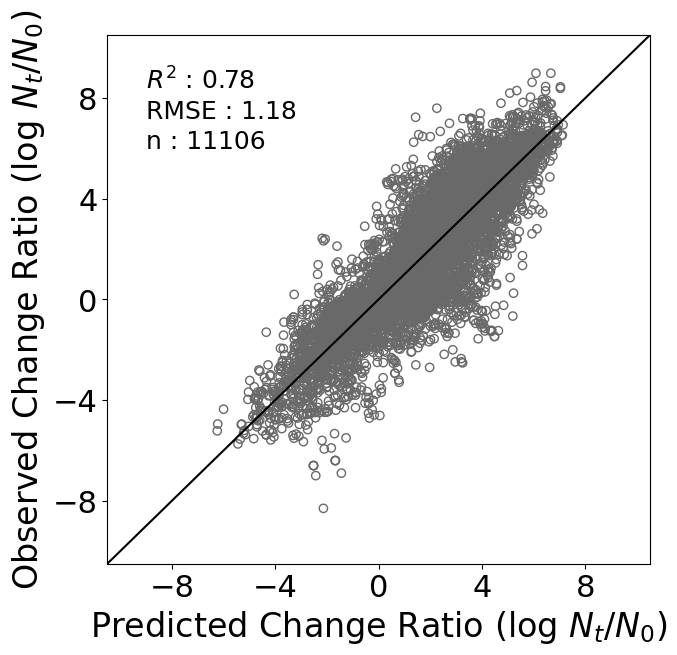

In [ ]:
#graph (Figure 1)
fig = plt.figure(figsize=(7,7))
plt.xlim(-10.5,10.5)
plt.ylim(-10.5,10.5)
plt.xticks([-8,-4,0,4,8])
plt.yticks([-8,-4,0,4,8])
plt.tick_params(labelsize=22, direction='out')    
x = np.arange(-11,11.5)
y = x
plt.plot(x,y, color='k')
plt.text(-9,6,'$R^2$ : {:.2f}\nRMSE : {:.2f}\nn : {:.0f}'.format(R2,RMSE,len(Test)),fontsize=18,linespacing=1.3)
plt.scatter(Test['Pred'],Test['Change_Ratio'],edgecolors='dimgray',facecolors='none')
plt.xlabel("Predicted Change Ratio (log $N_{t}$/$N_{0}$)", fontsize=24)
plt.ylabel("Observed Change Ratio (log $N_{t}$/$N_{0}$)", fontsize=24)
fig.patch.set_alpha(0)

In [ ]:
# Fig for Paper
# 'Aeromonas hydrophila': 1, 'Bacillus cereus': 2, 'Escherichia coli': 3, 'Listeria monocytogenes/innocua': 4, 'Pseudomonads': 5, 'Staphylococcus aureus': 6, 'Salmonella spp': 7, 'Yersinia enterocolitica': 8

#graph(figure 2(a)-(h))
# [chr(i) for i in range(ord('a'), ord('h')+1)]
fig_s = [chr(i) for i in range(97, 97+8)]


fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(80,40))
ax = ax.flatten()
spines = 2
sizeM = 50
sizeL = 55
sizeLL = 65

# Prepare Data
for i in range(1,9):
    j = i - 1
    test= Test[(Test['Organism'] ==i)]
    R2_test = metrics.r2_score(test['Change_Ratio'], test['Pred']) 
    RMSE_test = rmse_score(test['Change_Ratio'], test['Pred'])
    print(R2_test)
    print(RMSE_test)
    print(len(test))
    ax[j].set_xlim(-9.5,9.5)
    ax[j].set_ylim(-9.5,9.5)
    ax[j].set_xticks([-8,-4,0,4,8])
    ax[j].set_yticks([-8,-4,0,4,8])
    ax[j].tick_params(labelsize=sizeM, direction='out')    
    x = np.arange(-10,10)
    y = x
    ax[j].plot(x,y, color='k', linewidth=spines)
    ax[j].text(-9,8,'({:s})'.format(fig_s[j]),fontsize=sizeM)
    ax[j].spines["top"].set_linewidth(spines)
    ax[j].spines["left"].set_linewidth(spines)
    ax[j].spines["bottom"].set_linewidth(spines)
    ax[j].spines["right"].set_linewidth(spines)


# Organism Name
    if i == 1:
        ax[j].text(-1,-9,'$\it{A.hydrophila}$',fontsize=sizeLL)
    elif i == 2:
        ax[j].text(3,-9,'$\it{B.cereus}$',fontsize=sizeLL)
    elif i == 3:
        ax[j].text(4,-9,'$\it{E.coli}$',fontsize=sizeLL)
    elif i == 4:
        ax[j].text(-3,-9,'$\it{L.monocytogenes}$',fontsize=sizeLL)
    elif i == 5:
        ax[j].text(-1,-9,'$\it{Pseudomonads}$',fontsize=sizeLL)
    elif i == 6:
        ax[j].text(3,-9,'$\it{S.aureus}$',fontsize=sizeLL)
    elif i == 7:
        ax[j].text(2,-9,'$\it{Salmonella}$',fontsize=sizeLL)
    elif i == 8:
        ax[j].text(-2,-9,'$\it{Y.enterocolitica}$',fontsize=sizeLL)

    ax[j].text(-9,4,'$R^2$ : {:.2f}\nRMSE : {:.2f}\nn : {:.0f}'.format(R2_test,RMSE_test,len(test)),fontsize=sizeM,linespacing=1.3)
    ax[j].scatter(test['Pred'],test['Change_Ratio'],edgecolors='dimgray',facecolors='none',s=500, linewidth=3)

    ax[j].set_xlabel("Predicted Change Ratio (log $N_{t}$/$N_{0}$)", fontsize=sizeL)
    ax[j].set_ylabel("Observed Change Ratio (log $N_{t}$/$N_{0}$)", fontsize=sizeL)

fig.patch.set_alpha(0)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#each  Category
"""
# Organisms
'Aeromonas hydrophila': 1, 'Bacillus cereus': 2, 'Escherichia coli': 3, 
'Listeria monocytogenes/innocua': 4, 'Pseudomonads': 5, 'Staphylococcus aureus': 6, 
'Salmonella spp': 7, 'Yersinia enterocolitica': 8
# Categories
'Beef': 1, 'Culture medium': 2, 'Pork': 3, 'Poultry': 4, 
'Seafood': 5, 'Vegetable or fruit and their products': 6, 
'Water': 7, 'Dessert food': 8, 'Milk': 9, 'Sausage': 10, 
'Cheese': 11, 'Egg or egg product': 12, 'Juice, beverage': 13, 
'Sauce/dressing': 14, 'Bread': 15
"""

Organism_inv = {v: k for k, v in Organism.items()}
list_Org = [k for k,v in Organism.items()]
fig_s = ['j', 'k', 'l', 'm', 'n']
#graph(figure 2(a)-(h))
# [chr(i) for i in range(ord('a'), ord('h')+1)]
fig_s = [chr(i) for i in range(106, 118)]

category_name = ['Culture medium', 'Beef', 'Pork', 'Poultry', 'Seafood', 
                 'Vegetable or fruit', 'Dessert food', 'Milk', 'Cheese', 'Egg', 
                 'Juice, beverage', 'Bread']
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(100,60))
ax = ax.flatten()
spines = 2
sizeM = 50
sizeL = 55
sizeLL = 65

for i in range(1,16):
    test= Test[(Test['Category'] ==i)]
    R2_test = metrics.r2_score(test['Change_Ratio'], test['Pred']) 
    RMSE_test = rmse_score(test['Change_Ratio'], test['Pred'])
    print(R2_test)
    print(RMSE_test)
    print(len(test))
    if i==2:
        j = 0
        ax[j].text(-9,8,'(i)',fontsize=sizeM)
    elif i==1:
        j = i
        ax[i].text(-9,8,'({:s})'.format(fig_s[j-1]),fontsize=sizeM)
    elif (i==7) | (i==10) | (i==14):
        continue
    elif i<7:
        j = i - 1
        ax[j].text(-9,8,'({:s})'.format(fig_s[j-1]),fontsize=sizeM)
    elif i<10:
        j = i - 2
        ax[j].text(-9,8,'({:s})'.format(fig_s[j-1]),fontsize=sizeM)
    elif i<14:
        j = i - 3
        ax[j].text(-9,8,'({:s})'.format(fig_s[j-1]),fontsize=sizeM)
    else:
        j = i - 4
        ax[j].text(-9,8,'({:s})'.format(fig_s[j-1]),fontsize=sizeM)
    ax[j].set_xlim(-9.5,9.5)
    ax[j].set_ylim(-9.5,9.5)
    ax[j].set_xticks([-8,-4,0,4,8])
    ax[j].set_yticks([-8,-4,0,4,8])
    ax[j].tick_params(labelsize=sizeM, direction='out')    
    x = np.arange(-10,10)
    y = x
    ax[j].plot(x,y, color='k', linewidth=spines)
    ax[j].spines["top"].set_linewidth(spines)
    ax[j].spines["left"].set_linewidth(spines)
    ax[j].spines["bottom"].set_linewidth(spines)
    ax[j].spines["right"].set_linewidth(spines)
    ax[j].text(-9,4,'$R^2$ : {:.2f}\nRMSE : {:.2f}\nn : {:.0f}'.format(R2_test,RMSE_test,len(test)),fontsize=sizeM,linespacing=1.3)
    ax[j].text(-2,-9,category_name[j], fontsize=sizeLL)
    # ax[j].set_title(category_name[j], fontsize=40, pad=10, fontstyle='oblique')

    markers = ['x', ',', 'v', 'o', '>', '*', 'D', '4']
    colors1 = ['crimson', 'm', 'royalblue', 'skyblue', 'forestgreen', 'orangered', 'gold', 'rebeccapurple']
    for k,v in Organism.items():
        test_O = test[test['Organism']==v]
        if (v == 1) | (v == 8):
            ax[j].scatter(test_O['Pred'], test_O['Change_Ratio'], s=800, alpha=1, edgecolors=colors1[v-1], facecolors=colors1[v-1], marker=markers[v-1], label=k)
        else:
            ax[j].scatter(test_O['Pred'], test_O['Change_Ratio'], s=500, alpha=1, edgecolors=colors1[v-1], facecolors='None', marker=markers[v-1], label=k, linewidth=3)
    ax[j].set_xlabel("Predicted Change Ratio (log $N_{t}$/$N_{0}$)", fontsize=sizeL)
    ax[j].set_ylabel("Observed Change Ratio (log $N_{t}$/$N_{0}$)", fontsize=sizeL)
    if j ==11:
       ax[j].legend(labels=('Residual=0','Aeromonas hydrophila', 'Bacillus cereus', 'Escherichia coli', 'Listeria monocytogenes', 'Pseudomonads', 'Staphylococcus aureus', 'Salmonella', 'Yersinia enterocolitica'), fontsize=sizeM, loc='lower left', bbox_to_anchor=(1.1,0), frameon=False)

ax[12].axis('off')
ax[13].axis('off')
ax[14].axis('off')

fig.patch.set_alpha(0)

Output hidden; open in https://colab.research.google.com to view.

,Feature,Importance
0,Category,0.092464
1,Name,0.092920
2,Temperature,0.116022
3,Time,0.116189
4,pH,0.121171
5,Organism,0.146876
6,Aw,0.156392
7,N0,0.157966


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


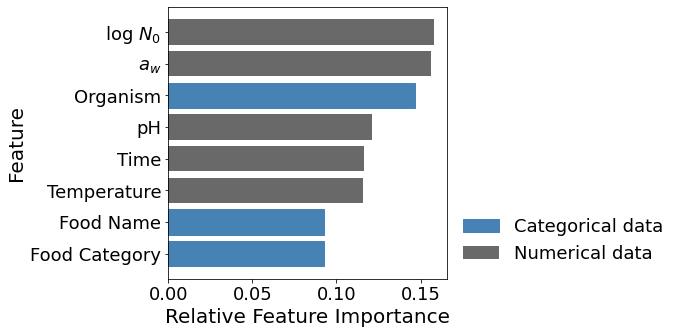

In [ ]:
# Feature_Importance Fig & dataframe
fti = model.feature_importances_
df_FI = pd.DataFrame(
                        data = {'Feature':train_x.columns, 'Importance':fti}
                        ).sort_values('Importance')
df_FI = df_FI.reset_index(drop=True)
display(df_FI)

df_FI['Feature'].replace({'N0':'log $N_0$', 'Category':'Food Category', 'Name':'Food Name', 'Aw':'$a_w$'}, inplace=True)
possition = df_FI['Feature']
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
FI_bar = ax.barh(possition, df_FI['Importance'], tick_label=df_FI['Feature'], color='dimgray')
FI_bar[0].set_color('steelblue')
FI_bar[1].set_color('steelblue')
FI_bar[5].set_color('steelblue')
ax.set_ylabel('Feature', fontsize=20)
ax.set_xlabel('Relative Feature Importance', fontsize=20)
ax.legend([FI_bar[0], FI_bar[7]], ['Categorical data','Numerical data'], fontsize=18, loc='lower left', bbox_to_anchor=(1,0), frameon=False)

plt.tick_params(labelsize=18,direction='out')
fig.patch.set_alpha(0)
plt.show()


In [ ]:
%%time
# SHAP
# loading JS
shap.initjs()

explainer_shap = shap.TreeExplainer(
                                    model=model, 
                                    data=None, 
                                    feature_perturbation='tree_path_dependent', 
                                    # feature_perturbation='interventional', 
                                    model_output='raw'
                                    )

shap_contrib = explainer_shap.shap_values(
                                          X=test_x, 
                                          y=None, 
                                          approximate=False, 
                                          check_additivity=True, 
                                           # check_additivity=False, 
                                          from_call=False
                                         )

# display as dataframe
df_shap = pd.DataFrame(shap_contrib, 
                       columns=['t_shap','N0_shap', 'T_shap', 'Aw_shap', 'pH_shap', 'Cate_shap', 'Name_shap', 'Org_shap']
                      )

display(df_shap)


In [ ]:
# merge Test&SHAP dataframe
Test_xpl =Test.copy().reset_index(drop=True)
Test_xpl = pd.concat([Test_xpl, df_shap], axis=1)
display(Test_xpl)


In [ ]:
# Shap_Features
# testdata

df_xpl = Test_xpl.copy()

t = df_xpl['Time']
Pred = df_xpl['Pred']

aw = df_xpl['Aw']
Shap_aw = df_xpl['Aw_shap']
pH = df_xpl['pH']
Shap_pH = df_xpl['pH_shap']
T = df_xpl['Temperature']
Shap_T = df_xpl['T_shap']

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(60,20))
ax = ax.flatten()

ax[0].set_xlim(0.175,1.025)
ax[0].set_xticks([0.2,0.4,0.6,0.8,1.00])
ax[1].set_xlim(2.5,10.5)
ax[1].set_xticks([3,4,5,6,7,8,9,10])
ax[2].set_xlim(-2,27)
ax[2].set_xticks([0,5,10,15,20,25])

for i in range(3):
    ax[i].set_ylim(-3.75,3.75)
    ax[i].set_yticks([-3,-2,-1,0,1,2,3])
    ax[i].tick_params(axis='both', labelsize= 55, direction='out')


ax[0].scatter(aw, Shap_aw, marker='o', s=500, linewidths=2, facecolors='None', edgecolors='steelblue', zorder=1, alpha=1)
ax[1].scatter(pH, Shap_pH, marker='o', s=500, linewidths=2, facecolors='None', edgecolors='steelblue', zorder=1, alpha=1)
ax[2].scatter(T, Shap_T, marker='o', s=500, linewidths=2, facecolors='None', edgecolors='steelblue', zorder=1, alpha=1)


ax[0].text(0.2,3.3,'(a)', fontsize=60)
ax[1].text(2.7,3.3,'(b)', fontsize=60)
ax[2].text(-1,3.3,'(c)', fontsize=60)


ax[0].set_ylabel('SHAP Value of $a_{w}$ (log $N_{t}$/$N_{0}$)', fontsize=60)
ax[0].set_xlabel('$a_{w}$', fontsize=60)
ax[1].set_ylabel('SHAP Value of pH (log $N_{t}$/$N_{0}$)', fontsize=60)
ax[1].set_xlabel('pH', fontsize=60)
ax[2].set_ylabel('SHAP Value of Temperature (log $N_{t}$/$N_{0}$)', fontsize=60)
ax[2].set_xlabel('Temperature [°C]', fontsize=60)

fig.patch.set_alpha(0)
plt.tight_layout()



In [ ]:


def custom_ncmap(color,n):
    cmap = cm.get_cmap(color,n) #colormapと分割数の指定

    color_list = []
    for i in range(cmap.N):
        rgb = cmap(i)[:n-1]
        color_list.append(rgb2hex(rgb))
    return color_list


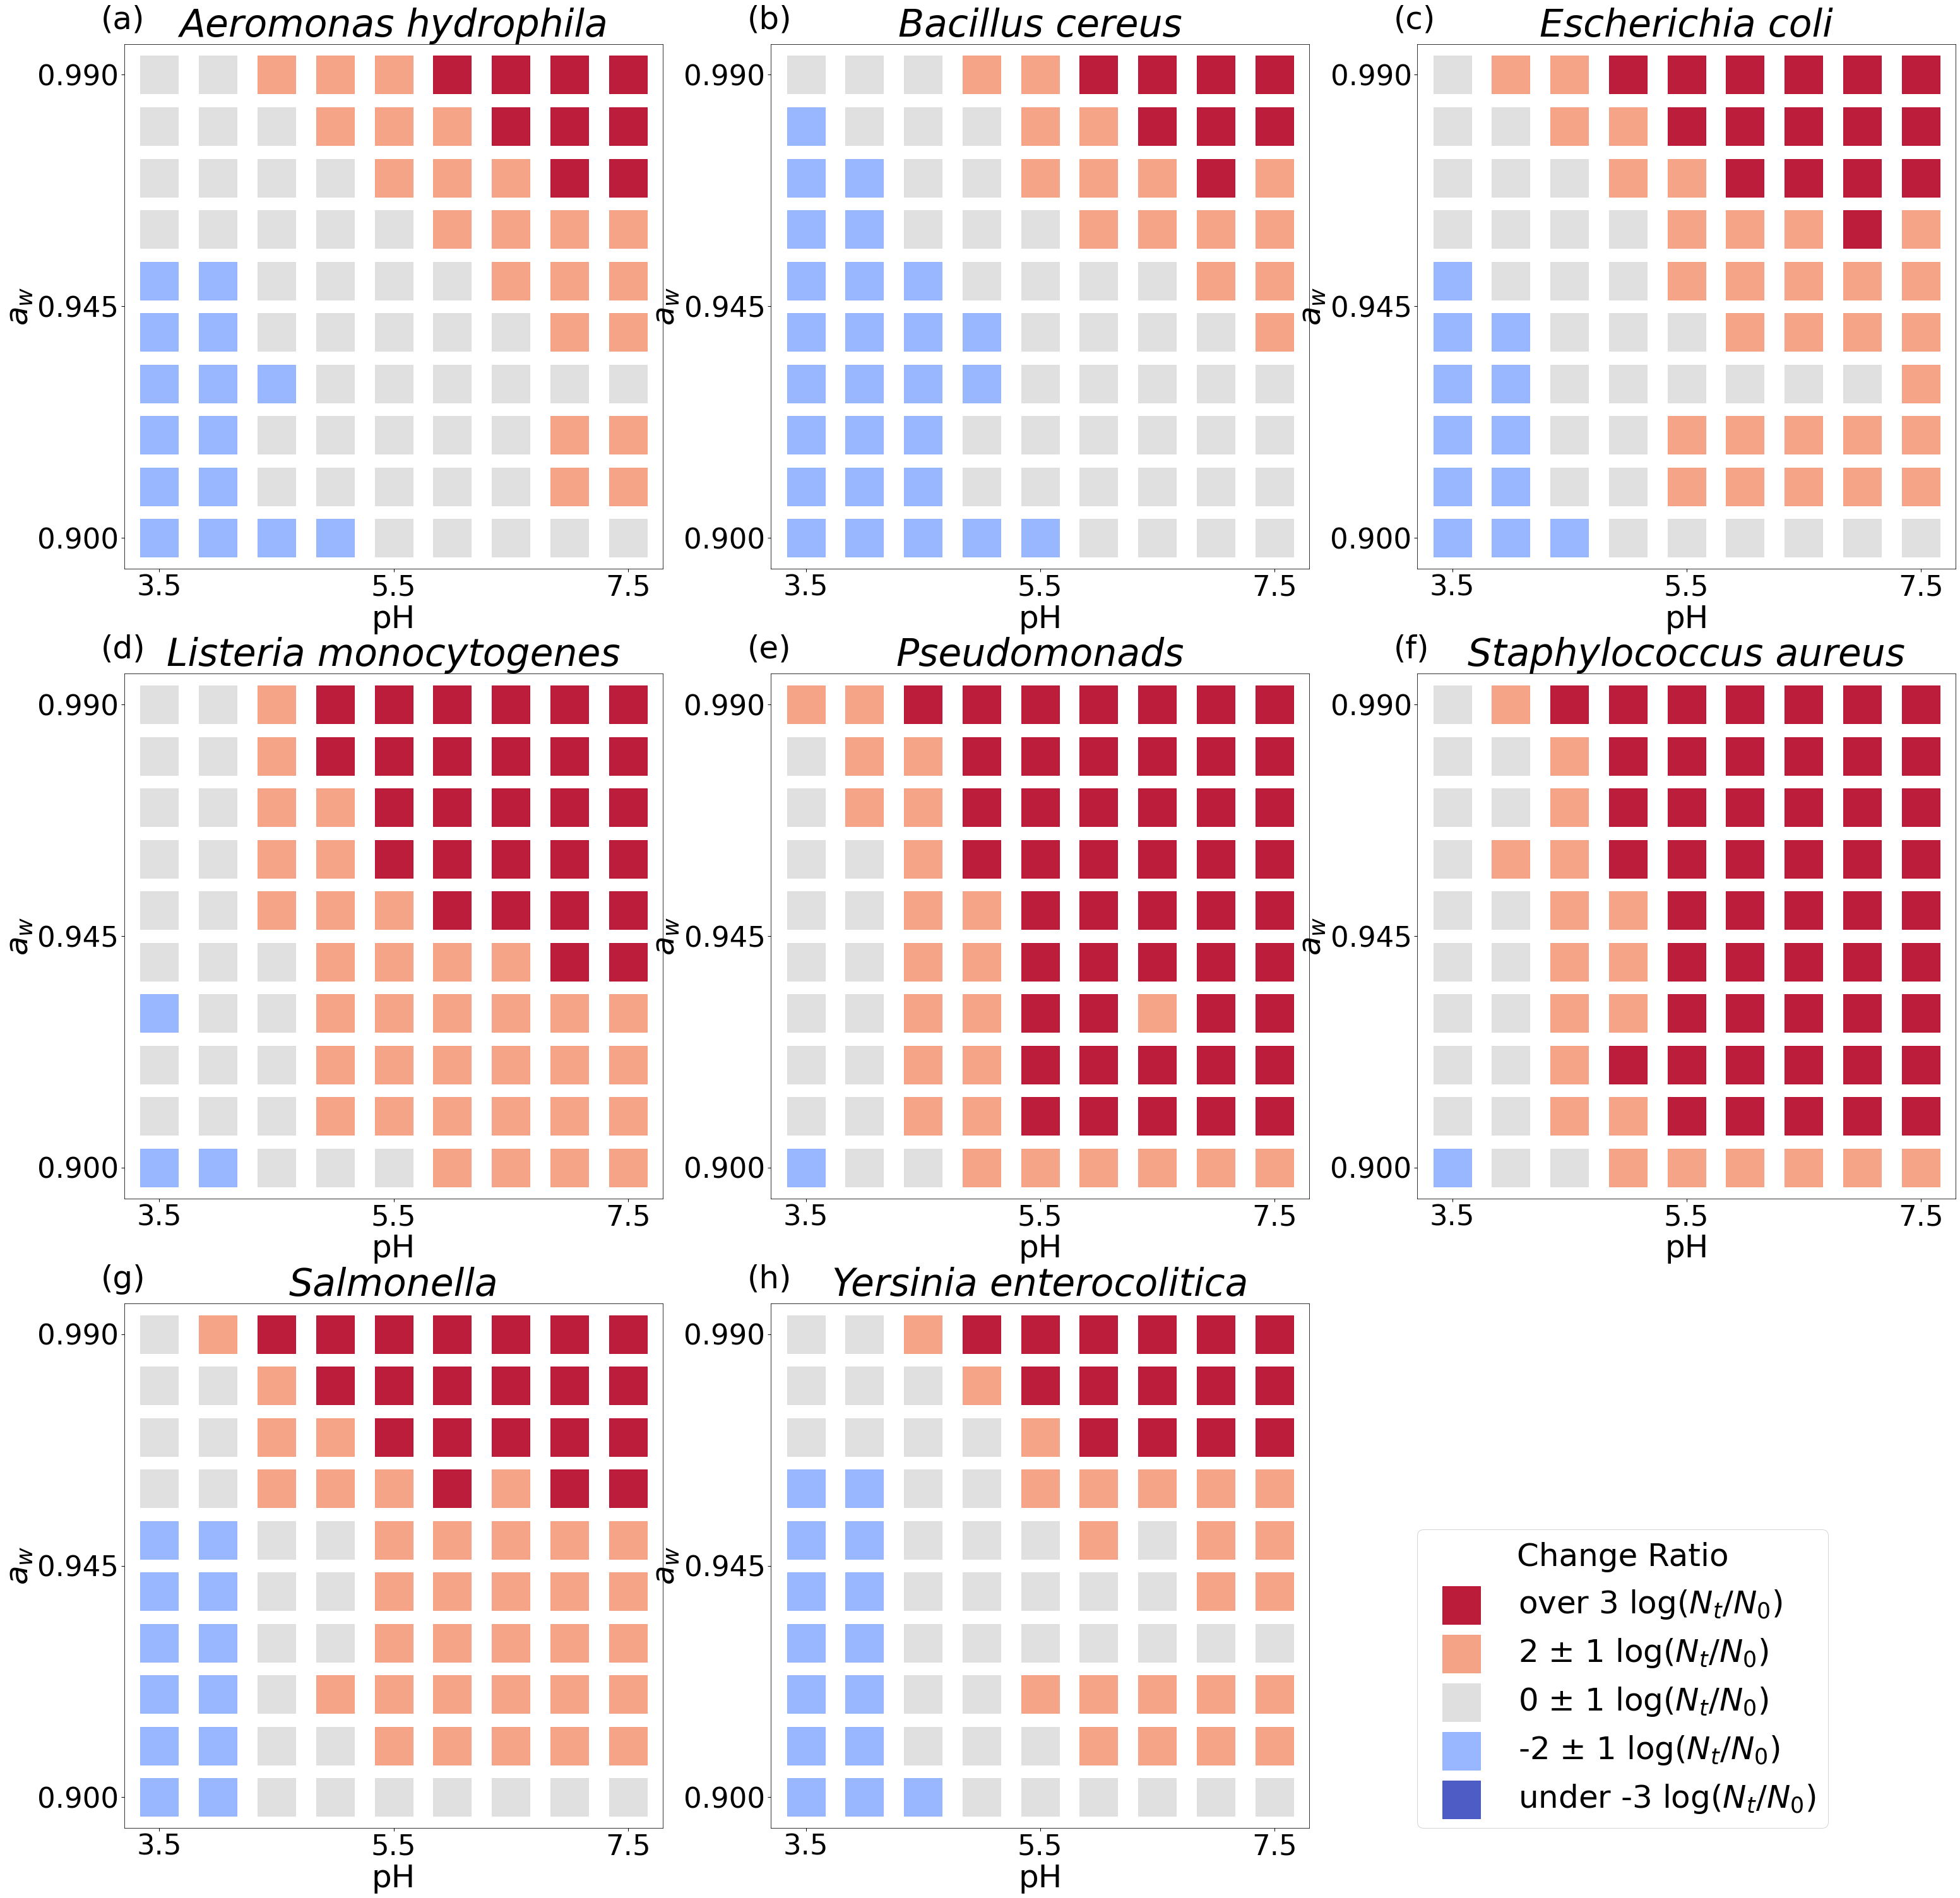

In [ ]:
# pH-aw
# slide

# Organism →   'Aeromonas hydrophila': 1, 'Bacillus cereus': 2, 'Escherichia coli': 3, 'Listeria monocytogenes/innocua': 4, 'Pseudomonads': 5, 'Staphylococcus aureus': 6, 'Salmonella spp': 7, 'Yersinia enterocolitica': 8
# Food Name →  'Broth': 4, 'Tsb': 6, 'Tpb': 130

df = pd.read_csv('data_pred_short.csv')
d0 = df[(df['Time']==240.0)&(df['Temperature']==20)]

fig_s = [chr(i) for i in range(97, 97+8)]
l_organism = ['Aeromonas hydrophila', 'Bacillus cereus', 'Escherichia coli', 'Listeria monocytogenes/innocua', 'Pseudomonads', 'Staphylococcus aureus', 'Salmonella spp', 'Yersinia enterocolitica']
name_organism = ['Aeromonas hydrophila', 'Bacillus cereus', 'Escherichia coli', 'Listeria monocytogenes', 'Pseudomonads', 'Staphylococcus aureus', 'Salmonella', 'Yersinia enterocolitica']


# df = pd.read_csv('data_pred_8Org.csv')
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(52,52))
ax = ax.flatten()

cmap = custom_ncmap('coolwarm',5)
spines = 2
sizeS = 30
sizeM = 45
sizeL = 50


for i in range(len(l_organism)):

    # setting
    d = d0[(d0['Name']=='Broth')&(d0['Organism']==l_organism[i])]
    # data split1_setting
    d_0 = d[(d['Predict']>=-1.0)&(d['Predict']<1.0)]
    d_n1 = d[(d['Predict']>=-3.0)&(d['Predict']<-1.0)]
    d_p1 = d[(d['Predict']>=1.0)&(d['Predict']<3.0)]
    d_n2 = d[(d['Predict']<-3.0)]
    d_p2 = d[(d['Predict']>=3.0)]
    # zero
    aw_0 = d_0['Aw']
    pH_0 = d_0['pH']
    # negative
    aw_n1 = d_n1['Aw']
    pH_n1 = d_n1['pH']
    aw_n2 = d_n2['Aw']
    pH_n2 = d_n2['pH']
    # positive(growth)
    aw_p1 = d_p1['Aw']
    pH_p1 = d_p1['pH']
    aw_p2 = d_p2['Aw']
    pH_p2 = d_p2['pH']

    ax[i].set_xlim(3.2,7.8)    
    ax[i].set_ylim(0.894,0.996)
    ax[i].set_xticks([3.5,5.5,7.5])
    ax[i].set_yticks([0.90,0.945,0.99])
    ax[i].tick_params(axis='both', labelsize= 45, direction='out', width=1.0, length=5.0)
    ax[i].set_xlabel('pH', fontsize=50)
    ax[i].set_ylabel('$a_{w}$', fontsize=50)
    org_name = '{}'.format(name_organism[i])
    ax[i].set_title(org_name, fontsize=60, pad=10, fontstyle = 'italic')
    ax[i].text(3,0.999,'({:s})'.format(fig_s[i]),fontsize=sizeL)

    ax[i].scatter(pH_p2, aw_p2, marker='s', facecolor=cmap[4], edgecolors=cmap[4], s=3500, zorder=1, alpha=0.9)
    ax[i].scatter(pH_p1, aw_p1, marker='s', facecolor=cmap[3], edgecolors=cmap[3], s=3500, zorder=1, alpha=0.9)
    ax[i].scatter(pH_0, aw_0, marker='s', facecolor=cmap[2], edgecolors=cmap[2], s=3500, zorder=1, alpha=0.9)
    ax[i].scatter(pH_n1, aw_n1, marker='s', facecolor=cmap[1], edgecolors=cmap[1], s=3500, zorder=1, alpha=0.9)
    ax[i].scatter(pH_n2, aw_n2, marker='s', facecolor=cmap[0], edgecolors=cmap[0], s=3500, zorder=1, alpha=0.9)
    if i == 7:
        lg = ax[i].legend(labels=(r'over 3 log($N_{t}$/$N_{0}$)', '2 $\pm $ 1 log($N_{t}$/$N_{0}$)', '0 $\pm $ 1 log($N_{t}$/$N_{0}$)', '-2 $\pm $ 1 log($N_{t}$/$N_{0}$)', 'under -3 log($N_{t}$/$N_{0}$)'), loc=(1.2,0), fontsize=sizeL, frameon=True, title='Change Ratio')
        lg.get_title().set_fontsize(50)
ax[8].axis('off')
fig.patch.set_alpha(0)
